<a href="https://colab.research.google.com/github/Morningspread/Angry-Tweeter/blob/main/Dataprep_Anger_Twitter_May9%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective: I want to see if we can create a viable training regime on Twitter data 

This is not suitable for a production environment. 

In [ ]:
#Import libraries... 

import nltk
import os
import pandas as pd

import os
from collections import defaultdict
from collections import Counter
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')


import re
from concurrent.futures import ThreadPoolExecutor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Setting display options 

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set maximum number of rows and columns to display
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the inference datasets...

path = "/content/drive/MyDrive/Sean/Emoclass/Kaggle_1.6million_.noemoticon.csv"

# Define the column names
column_names = ['Target','Index', 'Date', 'Query', 'User_ID', 'text']

# Read the CSV file with the specified column names and encoding
df = pd.read_csv(path, encoding='ISO-8859-1', names=column_names)

# Print the first few rows of the DataFrame to verify that the data was read correctly
print(df.head())


   Target       Index                          Date     Query  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           User_ID                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


#Setting the emotion axis 

In [ ]:
#Anger Schema - May 4,2023  
#If we call it emo_axis -> we don't have to change it across capabilities....

emo_axis = {
    "rage": ['rage', 'raging', 'raged', 'fury', 'wrath', 'wrathful', 'furious', 'enraged', 'enraging', 'incensed', 'outraged'],
    "angry": ["angry", "anger", "angered", "mad", "maddening", "maddened"],
    "frustrated": ["frustration", "frustrate", "frustrated", "frustrating", "exasperated", "exasperating", "discontented", "vexed", "vexing", "bothered", "bothersome"],
    "agitated": ["agitated", "agitating", "agitation", "aggravated", "aggravation", "aggravating", "upset", 'upsetting', 'irritate', 'irritating', 'irritable', 'irritated'],
    "annoyed": ["annoying", "annoy", "annoyed", "pestered", "pestering", "pester", "troubled", "troubling", "disturbed", "disturbing", "harassed", "harassing", "nagged", "nagging"],
    "calm": ["calm", "peaceful", "serene", "serenity", "relax", "relaxing", "relaxed"]
}    

#Cleaning the data 

I think all tweets are in english... 

In [ ]:
# define a function to remove @handles, URLs, hashtags, and apostrophes from a string
def preprocess_text(text):
    text = re.sub(r'@\w+\s?', '', text) # remove @handles
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'#\w+\s?', '', text) # remove hashtags
    text = text.replace("'", "") # remove apostrophes
    text = text.replace("?", "") # remove question marks
    text = text.replace("!", "") # remove exclamation marks
    return text


In [ ]:
# apply the function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

#Searching for the words... 

This code is compute optimized 

In [ ]:
# Function to find the first matching word and its corresponding key in the emo_axis dictionary, considering word boundaries
def find_first_matching_word(text, emo_axis):
    words = text.split()

    for word in words:
        lower_word = word.lower()
        for key, values in emo_axis.items():
            if lower_word in values:
                return lower_word, key

    return None, None


In [ ]:
#Applying the function...

# Apply the find_first_matching_word function to the 'text' column of the DataFrame
df['match'] = df['text'].apply(lambda x: find_first_matching_word(x, emo_axis))

# Create a new DataFrame with the desired structure
result_df = pd.DataFrame({'text': df['text'], 'emotion1': [match[0] for match in df['match']], 'emotion2': [match[1] for match in df['match']]})

# Filter the DataFrame to include only rows with key emotion words
filtered_df = result_df[result_df['emotion1'].notna()]

print(filtered_df.shape)

(15212, 3)


In [ ]:
#Basic diagnostics 

filtered_df['emotion2'].value_counts()


angry         4244
calm          3457
annoyed       3024
agitated      2706
frustrated    1381
rage           400
Name: emotion2, dtype: int64

In [ ]:
filtered_df['emotion1'].value_counts()

mad             3353
upset           2237
annoying        1677
relaxing        1611
relax            949
annoyed          846
angry            736
bothered         483
frustrated       453
calm             381
frustrating      354
relaxed          231
peaceful         226
annoy            164
upsetting        155
anger            136
irritated        135
rage             121
disturbing       116
furious          104
irritating       102
raging            83
frustration       69
disturbed         62
nagging           48
serenity          41
wrath             41
fury              31
harassing         24
aggravated        20
pestering         19
troubled          19
serene            18
irritable         17
troubling         16
aggravating       16
irritate          14
harassed          13
pester            11
angered           10
maddening          9
frustrate          8
agitated           8
outraged           8
nagged             7
bothersome         7
raged              6
enraged      

#Exploring and renaming the dataset

In [ ]:
df = filtered_df

In [ ]:
#Function to count word length...

def count_words(text):
    return len(text.split())

In [ ]:
#Applying the function to count words... 

df['num_words'] = df['text'].apply(count_words)

<ipython-input-14-1cb45a25e07c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_words'] = df['text'].apply(count_words)


In [ ]:
#Basic descriptives - mean of 18.2 SD of 5.6 

#df['num_words'].describe()

<ipython-input-16-e9381995cfc8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_words'] = df['text'].apply(count_words)


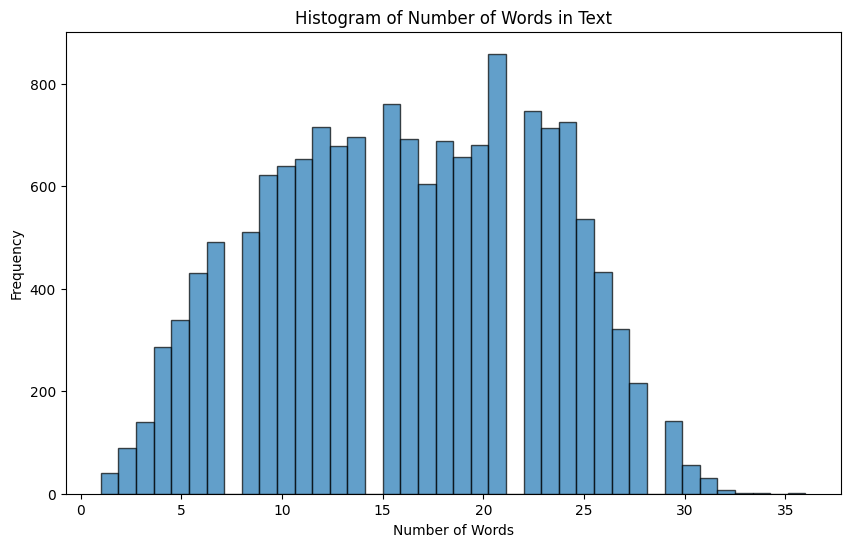

In [ ]:
import matplotlib.pyplot as plt

# Apply the count_words function to the 'text' column of the DataFrame
df['num_words'] = df['text'].apply(count_words)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['num_words'], bins='auto', edgecolor='black', alpha=0.7)
plt.title('Histogram of Number of Words in Text')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


#Data Augmentation 

##First define the ratios properly... 

In [ ]:
import pandas as pd

# First, define the proper ratios

# Create a DataFrame to look at the proportion of classes in the dataframe

# Step 1: Create a DataFrame containing the current class distribution
emo_axis_keys = list(emo_axis.keys())
current_class_distribution = df['emotion2'].value_counts().loc[emo_axis_keys].reset_index()
current_class_distribution.columns = ['emotion', 'count']

# Add the proportion column
current_class_distribution['proportion'] = current_class_distribution['count'] / current_class_distribution['count'].sum()

# Step 2: Calculate the ratios between the dominant class and the other classes
majority_class_proportion = current_class_distribution['proportion'].max()

ratios = current_class_distribution['proportion'] / majority_class_proportion
ratios_dict = {emotion: ratio for emotion, ratio in zip(current_class_distribution['emotion'], ratios)}

# Step 3: Add the ratios to the current_class_distribution DataFrame
current_class_distribution['ratio_to_majority'] = ratios

print(current_class_distribution)


      emotion  count  proportion  ratio_to_majority
0        rage    400       0.026              0.094
1       angry   4244       0.279              1.000
2  frustrated   1381       0.091              0.325
3    agitated   2706       0.178              0.638
4     annoyed   3024       0.199              0.713
5        calm   3457       0.227              0.815


##Now Resampling the Dataframe

In [ ]:
#New ChatGPT function to fix the fact that it's not paying proper attention to the total dataset sizem- May 4, 2023

def resample_dataset_v4(df, class_distribution_df, emotion_col, total_dataset_size, min_ratio):
    weights = [max(min_ratio, ratio_to_majority) for ratio_to_majority in class_distribution_df['ratio_to_majority']]
    weight_sum = sum(weights)
    
    majority_class_size = int(total_dataset_size / weight_sum)

    desired_class_sizes = {
        emotion: int(majority_class_size * max(min_ratio, ratio_to_majority))
        for emotion, ratio_to_majority in zip(class_distribution_df['emotion'], class_distribution_df['ratio_to_majority'])
    }

    resampled_df_list = []

    for emotion, desired_size in desired_class_sizes.items():
        class_df = df[df[emotion_col] == emotion].sample(desired_size, random_state=42, replace=True)
        resampled_df_list.append(class_df)

    resampled_df = pd.concat(resampled_df_list)

    return resampled_df


##Applying the resampling function 

In [ ]:
total_dataset_size = 100000  # Example value
min_ratio = 1/4  # Example value

resampled_df = resample_dataset_v4(df, current_class_distribution, 'emotion2', total_dataset_size, min_ratio)
print(resampled_df['emotion2'].value_counts())


angry         26737
calm          21778
annoyed       19051
agitated      17047
frustrated     8700
rage           6684
Name: emotion2, dtype: int64


In [ ]:
#Renaming the dataset again

df = resampled_df

In [ ]:
df.head()

,text,emotion1,emotion2,num_words
348833,Mother furious with me. I ate her breakfast wh...,furious,rage,22
1375031,Watching the fast and the furious wiff sierra ...,furious,rage,13
1002753,"Kids are in bed, fast asleep, recuperating fro...",wrath,rage,23
365175,"havent received a mobile tweet all day wtf, tm...",raging,rage,22
222137,A lil WARM WEATHER &amp; NIGGAS start RAGING W...,raging,rage,20


#Define a function to remove stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def remove_stop_words(text, emotion_word):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words or word == emotion_word]
    return ' '.join(filtered_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Define a Function to Randomly Shorten 

In [ ]:
import random
from nltk import word_tokenize

def truncate_randomly(text):
    words = word_tokenize(text)

    min_length = 2
    max_length = len(words)

    # Generate a random length between min_length and max_length (inclusive)
    target_length = random.randint(min_length, max_length)

    # Truncate the text to the target length
    truncated_text = ' '.join(words[:target_length])

    return truncated_text



##New function to randomly shorten text length 

In [ ]:
import random
from nltk import word_tokenize

def truncate_randomly(text):
    words = word_tokenize(text)

    min_length = 2
    max_length = len(words)

    # Check if max_length is greater than min_length
    if max_length > min_length:
        # Generate a random length between min_length and max_length (inclusive)
        target_length = random.randint(min_length, max_length)

        # Truncate the text to the target length
        truncated_text = ' '.join(words[:target_length])
    else:
        # If max_length is equal to min_length, return the original text
        truncated_text = text

    return truncated_text


#Applying function to remove stop words and randomly shorten

In [ ]:
#Checking the dataset size and nature.

df.shape

(99997, 4)

In [ ]:
df.head()

,text,emotion1,emotion2,num_words
348833,Mother furious with me. I ate her breakfast wh...,furious,rage,22
1375031,Watching the fast and the furious wiff sierra ...,furious,rage,13
1002753,"Kids are in bed, fast asleep, recuperating fro...",wrath,rage,23
365175,"havent received a mobile tweet all day wtf, tm...",raging,rage,22
222137,A lil WARM WEATHER &amp; NIGGAS start RAGING W...,raging,rage,20


In [ ]:
import random
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize

# Assuming your existing data is in a DataFrame called df1 with columns 'text', 'emotion1', and 'emotion2'
# Shuffle the df DataFrame to mix the samples
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the dataset into three parts
num_samples = len(df) // 3
dfs = np.array_split(df, 3)

# Add the treatment column to each part of the dataset
treatments = ['Nothing', 'Remove Stop Words', 'Random Truncation']
for i, df in enumerate(dfs):
    df['treatment'] = treatments[i]

# Apply the remove_stop_words function to the second part of the dataset
for i, df in enumerate(dfs):
    if i == 1:
        df['text'] = df['text'].apply(lambda x: remove_stop_words(x, emotion_word=df['emotion2'].iloc[0]))

# Apply random truncation to the third part of the dataset
for i, df in enumerate(dfs):
    if i == 2:
        df['text'] = df['text'].apply(lambda x: truncate_randomly(x))

# Concatenate the three parts of the dataset back together
df_aug = pd.concat(dfs, ignore_index=True)


#Exploring the new dataset 

In [ ]:
# Applying the word length function
df_aug['new_word_length'] = df_aug['text'].apply(count_words)

In [ ]:
df_aug['new_word_length'].describe()

count   99997.000
mean       12.613
std         6.823
min         1.000
25%         7.000
50%        12.000
75%        17.000
max        50.000
Name: new_word_length, dtype: float64

In [ ]:
df_aug['treatment'].value_counts()

Nothing              33333
Remove Stop Words    33332
Random Truncation    33332
Name: treatment, dtype: int64

In [ ]:
#Checking the value counts of this... 
#df_aug['emotion1'].value_counts()

In [ ]:
#Taking a final look at the datset...

df_aug.head(100)

,text,emotion1,emotion2,num_words,treatment,new_word_length
0,"Ive studied lots in politics, but I specialize...",frustrated,frustrated,21,Nothing,21
1,I KNOW lmao i was mad dissapointed,mad,angry,7,Nothing,7
2,is aggravated and needs to get some sleep soon...,aggravated,agitated,25,Nothing,25
3,Is wondering why &quot; :O&quot; is an angry f...,angry,angry,11,Nothing,11
4,watched the first 3 episodes of Mad Men last n...,mad,angry,19,Nothing,19
5,And congrats to the fury for avoiding a defeat...,fury,rage,10,Nothing,10
6,Home from the hospital and mummy looked terrib...,upset,agitated,26,Nothing,26
7,"ARRGHHH, still itching Im on the border of g...",mad,angry,10,Nothing,10
8,Got a bunch of texts this morning from people ...,mad,angry,26,Nothing,26
9,why limit your story to 140 ch. Tell all what ...,annoying,annoyed,21,Nothing,21


#Exporting the dataset 

In [ ]:
#Exporting the anger dataset 

path = "/content/drive/MyDrive/Sean/Emoclass/Emotion datasets/Anger_Twit_Kaggle_100K_May10,2023.csv"
df_aug.to_csv(path, index=False)